<a href="https://colab.research.google.com/github/Rajvid22/Dissertation/blob/main/Cyber_Threat_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

### Importing Dependencies

In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import os
import re
from pathlib import Path

import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import spacy
from unicodedata import normalize

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
import seaborn as sns

### Loading Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Msc Dissertation/annotated.csv")

In [5]:
df.head()

,id,text,annotation,type
0,5b88752abb325e65390af240,Best way to build empathy is through honesty a...,irrelevant,['Vulnerability']
1,5b8875d5bb325e65a22cf81b,Cryptocurrency Scams Replacing Ransomware as A...,business,['ransomware']
2,5b88768dbb325e65fa7e78e3,Cryptocurrency Scams Replacing Ransomware as A...,business,['ransomware']
3,5b8876f9bb325e65fa7e78e4,Protect your customers access Prestashop Ant...,threat,['Ddos']
4,5b8876f9bb325e65fa7e78e5,Data leak from Huazhu Hotels may affect 130 mi...,threat,['leak']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          21368 non-null  object
 1   text        21368 non-null  object
 2   annotation  21368 non-null  object
 3   type        21368 non-null  object
dtypes: object(4)
memory usage: 667.9+ KB


### Column cleaning

In [7]:
df["type"].value_counts()

['vulnerability']                  6976
['general']                        6658
['ransomware']                     3140
['ddos']                           2174
['botnet']                          699
['0day']                            686
['General']                         340
['Vulnerability']                   286
['leak']                             93
['vulnerability', '0day']            86
['Ransomware']                       49
['Ddos']                             46
['0Day']                             44
['Leak']                             43
['ddos', 'botnet']                   13
['ddos', 'ransomware']               12
['All']                               7
['ransomware', 'botnet']              6
['Botnet']                            3
['vulnerability', 'ransomware']       3
['vulnerability', 'botnet']           2
['vulnerability', 'ddos']             1
['ransomware', '0day']                1
Name: type, dtype: int64

In [8]:
df.type

0        ['Vulnerability']
1           ['ransomware']
2           ['ransomware']
3                 ['Ddos']
4                 ['leak']
               ...        
21363           ['botnet']
21364       ['ransomware']
21365          ['general']
21366          ['general']
21367    ['vulnerability']
Name: type, Length: 21368, dtype: object

In [9]:
def clean_col(val):
  
  val = eval(val)
  val = val[0].lower() if len(val) == 1 else None

  return val

In [10]:
df["type"] = df["type"].apply(clean_col)
df.dropna(inplace=True)

In [11]:
df.type

0        vulnerability
1           ransomware
2           ransomware
3                 ddos
4                 leak
             ...      
21363           botnet
21364       ransomware
21365          general
21366          general
21367    vulnerability
Name: type, Length: 21244, dtype: object

In [12]:
df.isna().sum()

id            0
text          0
annotation    0
type          0
dtype: int64

In [13]:
df["type"].value_counts()

vulnerability    7262
general          6998
ransomware       3189
ddos             2220
0day              730
botnet            702
leak              136
all                 7
Name: type, dtype: int64

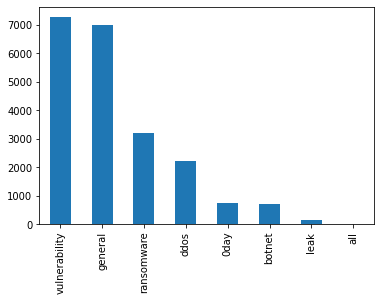

In [14]:
df["type"].value_counts().plot(kind = "bar")

In [15]:
df = df[df["type"] != "all"]

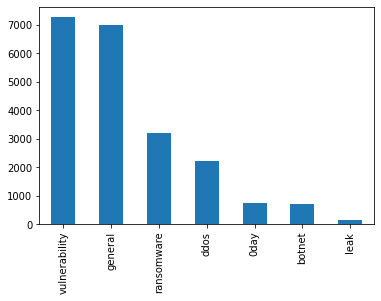

In [16]:
df["type"].value_counts().plot(kind = "bar")

### Label Encoding

In [17]:
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])

In [18]:
df["type"]

0        6
1        5
2        5
3        2
4        4
        ..
21363    1
21364    5
21365    3
21366    3
21367    6
Name: type, Length: 21237, dtype: int64

In [19]:
import joblib
joblib.dump(le,"/content/drive/MyDrive/Msc Dissertation/le.pickle")

['/content/drive/MyDrive/Msc Dissertation/le.pickle']

In [20]:
le.classes_

array(['0day', 'botnet', 'ddos', 'general', 'leak', 'ransomware',
       'vulnerability'], dtype=object)

### Cleaning the dataset

In [21]:
nlp = spacy.load("en_core_web_sm")

def clean_data(df, column):

  def lem_stp():

    for doc in nlp.pipe(df[column], disable=["parser", "ner"], batch_size=512):
        yield " ".join(
            [d.lemma_ for d in doc if not d.is_stop]
        )
  
  def clean(text):

    text = str(text).strip()

    if text:
      
      #Normalize Text
      text = normalize("NFKD", text)

      #Remove links 
      text = re.sub(r'https?:\/\/.*?[\s+]', '', text.replace("|"," ") + " ")

      #Strip Punctation
      text = re.sub(r'[^\w\s]','', text)

    return text.strip()

  df[column] = df[column].apply(clean)
  df[column] = list(lem_stp())
  df[column] = df[column].apply(lambda x: re.sub("\s+", " ", x.strip()))
  df[column] = df[column].apply(lambda x: x if len(x.split()) >= 5 else None)

  return df[column]

In [22]:
df["Cleaned"] = clean_data(df, "text")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
df["text"][1000]

'CVE201816384 SQL injection bypass aka PL1 bypass exist OWASP ModSecurity Core Rule Set owaspmodsecurity'

In [24]:
df["Cleaned"][1000]

'CVE201816384 SQL injection bypass aka PL1 bypass exist OWASP ModSecurity Core Rule Set owaspmodsecurity'

### Tokenization

In [25]:
# checkpoint = "bert-base-uncased"
checkpoint = "gpt2"
sequence_length = 256

def tokenize(df, column):

  tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  if checkpoint == "gpt2" and tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  X = df[column].tolist()

  tokens = tokenizer(
      X,
      max_length=sequence_length,
      truncation=True,
      padding="max_length",
      add_special_tokens=True,
      return_tensors="np"
  )

  return {"input_ids": tokens["input_ids"].tolist(), "attention_mask": tokens["attention_mask"].tolist()}

### Splitting Data into Train/Test

In [26]:
unzip_x = lambda x: [np.vstack(x["input_ids"]), np.vstack(x["attention_mask"])]

X = pd.DataFrame(tokenize(df, "Cleaned"), columns=["input_ids", "attention_mask"])
y = df["type"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

X_train, X_test = unzip_x(X_train), unzip_x(X_test)

Using pad_token, but it is not set yet.


### Taking the pre-trained model

In [27]:
base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Building the model

In [28]:
def build_model(df, targets, checkpoint, sequence_length):

  base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

  input_ids = Input(shape=(sequence_length,), name="input_ids", dtype="int32")
  attenion_mask = Input(shape=(sequence_length,), name="attention_mask", dtype="int32")

  if checkpoint == "gpt2": x1 = base_model.transformer(input_ids, attention_mask=attenion_mask)[0]
  else: x1 = base_model.bert(input_ids, attention_mask=attenion_mask)[1]

  x1 = Flatten()(x1)

  units = df[targets].nunique()

  if units > 2:
      activation = "softmax"
      loss = "sparse_categorical_crossentropy"
  else:
      activation = "sigmoid"
      loss = "binary_crossentropy"
      units = units - 1

  outputs = Dense(units, activation = activation, name = f"{targets}_outputs")(x1)

  model = Model(inputs=[input_ids, attenion_mask], outputs=outputs)

  optimizer =  tf.keras.optimizers.Adam()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

  tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/Msc Dissertation/model.png', show_shapes=True, 
                            show_dtype=True, show_layer_names=True, rankdir='TB',
                            expand_nested=True, dpi=300, layer_range=None, 
                            show_layer_activations=True)

  return model

In [29]:
model = build_model(df, "type", checkpoint, sequence_length)

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 transformer (TFGPT2MainLayer)  TFBaseModelOutputWi  124439808   ['input_ids[0][0]',              
                                thPastAndCrossAtten               'attention_mask[0][0]']         
                                tions(last_hidden_s                                               
                                tate=(None, 256, 76                                           

### Callbacks

In [31]:
def callbacks() -> list:

    run_name = "run 1"
    save_path = Path("/content/drive/MyDrive/Msc Dissertation/models")
    os.makedirs(save_path/"logs", exist_ok=True)
    
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, 
                                                    verbose=1)

    earlystopping = EarlyStopping(monitor="val_loss", verbose=1, restore_best_weights = True,
                                                    patience=5)

    logger = TensorBoard(save_path/"logs"/run_name, histogram_freq=2, write_graph=True, write_images=True)

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1,
                                         min_delta=0.0001, cooldown=0, min_lr=0)
    
    return [checkpoint, earlystopping, lr, logger]

### Training the model

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=8, callbacks=callbacks())

Epoch 1/20
1980/1980 [==============================] - ETA: 0s - loss: 1.4635 - accuracy: 0.8200
Epoch 1: val_loss improved from inf to 0.46444, saving model to /content/drive/MyDrive/Msc Dissertation/models


1980/1980 [==============================] - 676s 334ms/step - loss: 1.4635 - accuracy: 0.8200 - val_loss: 0.4644 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 2/20
 510/1980 [======>.......................] - ETA: 6:43 - loss: 0.4217 - accuracy: 0.9017

KeyboardInterrupt: ignored

### Testing

In [33]:
lmodel = tf.keras.models.load_model("/content/drive/MyDrive/Msc Dissertation/models")

In [ ]:
lmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 transformer (TFGPT2MainLayer)  TFBaseModelOutputWi  124439808   ['input_ids[0][0]',              
                                thPastAndCrossAtten               'attention_mask[0][0]']         
                                tions(last_hidden_s                                               
                                tate=(None, 256, 76                                         

In [ ]:
ypred = lmodel.predict(X_test)

In [ ]:
ypred = np.argmax(ypred, axis=-1)

In [ ]:
le.classes_

array(['0day', 'botnet', 'ddos', 'general', 'leak', 'ransomware',
       'vulnerability'], dtype=object)

In [ ]:
report = classification_report(y_test, ypred, target_names=le.classes_)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(report)

               precision    recall  f1-score   support

         0day       0.92      0.93      0.92       144
       botnet       0.91      0.94      0.92       132
         ddos       0.98      0.92      0.95       419
      general       0.88      0.84      0.86      1290
         leak       0.00      0.00      0.00        27
   ransomware       0.96      0.97      0.97       599
vulnerability       0.89      0.95      0.91      1349

     accuracy                           0.91      3960
    macro avg       0.79      0.79      0.79      3960
 weighted avg       0.90      0.91      0.90      3960



In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
 

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("cm.png", dpi=300)
    plt.show()


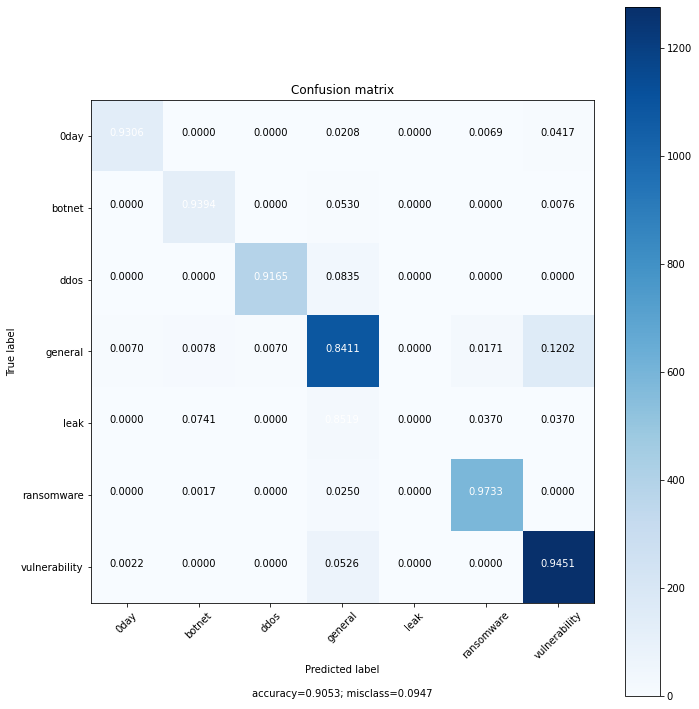

In [ ]:
cm = confusion_matrix(y_test, ypred)
plot_confusion_matrix(cm, le.classes_)